In [1]:
import os   
os.chdir('/Users/ogeohia/PYTHON/eo-colon-cancer-trends-ci5plus')

In [10]:

import pandas as pd
import numpy as np

In [50]:
colon_cancer_full = pd.read_csv("data/colon_cancer_full.csv")
display(colon_cancer_full.head())
colon_cancer_full.shape


cases       py  year  registry_code sex_label country continent  \
0      0  60462.0  1993         800002      Male  Uganda    Africa   
1      0  72770.0  1993         800002      Male  Uganda    Africa   
2      0  64952.0  1993         800002      Male  Uganda    Africa   
3      1  45156.0  1993         800002      Male  Uganda    Africa   
4      0  28283.0  1993         800002      Male  Uganda    Africa   

               region    hdi hdi_category  age_cont age_group  
0  Sub-Saharan Africa  0.582       Medium      17.5     Young  
1  Sub-Saharan Africa  0.582       Medium      22.5     Young  
2  Sub-Saharan Africa  0.582       Medium      27.5     Young  
3  Sub-Saharan Africa  0.582       Medium      32.5     Young  
4  Sub-Saharan Africa  0.582       Medium      37.5     Young

(92326, 12)

In [16]:
from patsy import dmatriximport statsmodels.api as sm# Create spline basis for age_cont (cubic splines with 4 degrees of freedom)spline_basis = dmatrix("bs(age_cont, df=4, include_intercept=False)", data=colon_cancer_full, return_type='dataframe')# Dummy encode sex_label and region, ensure all columns are floatX = pd.concat([    spline_basis,    pd.get_dummies(colon_cancer_full['sex_label'], drop_first=True),    pd.get_dummies(colon_cancer_full['region'], drop_first=True)], axis=1).astype(float)# Add intercept (statsmodels uses 'const' as the default name)X = sm.add_constant(X, has_constant='add')# Response variable: casesy = colon_cancer_full['cases']# Offset: log(py)offset = np.log(colon_cancer_full['py'])# Fit Poisson regressionpoisson_model = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)poisson_results = poisson_model.fit()print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                92326
Model:                            GLM   Df Residuals:                    92309
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7782e+05
Date:                Tue, 09 Sep 2025   Deviance:                   3.0963e+05
Time:                        01:31:29   Pearson chi2:                 3.12e+05
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [ ]:
# Predict expected counts
colon_cancer_full['predicted_counts'] = poisson_results.predict(X, offset=offset)
display(colon_cancer_full.head())

# Save the updated DataFrame with predictions to CSV
colon_cancer_full.to_csv('data/colon_cancer_full_with_predictions.csv', index=False)
print("colon_cancer_full with predictions saved to data/colon_cancer_full_with_predictions.csv")

# --- Poisson Regression Analysis ---


cases       py  year  registry_code sex_label country continent  \
0      0  60462.0  1993         800002      Male  Uganda    Africa   
1      0  72770.0  1993         800002      Male  Uganda    Africa   
2      0  64952.0  1993         800002      Male  Uganda    Africa   
3      1  45156.0  1993         800002      Male  Uganda    Africa   
4      0  28283.0  1993         800002      Male  Uganda    Africa   

               region    hdi hdi_category  age_cont age_group  \
0  Sub-Saharan Africa  0.582       Medium      17.5     Young   
1  Sub-Saharan Africa  0.582       Medium      22.5     Young   
2  Sub-Saharan Africa  0.582       Medium      27.5     Young   
3  Sub-Saharan Africa  0.582       Medium      32.5     Young   
4  Sub-Saharan Africa  0.582       Medium      37.5     Young   

   predicted_counts  
0          0.012237  
1          0.038171  
2          0.081009  
3          0.123121  
4          0.155336

colon_cancer_full with predictions saved to data/colon_cancer_full_with_predictions.csv


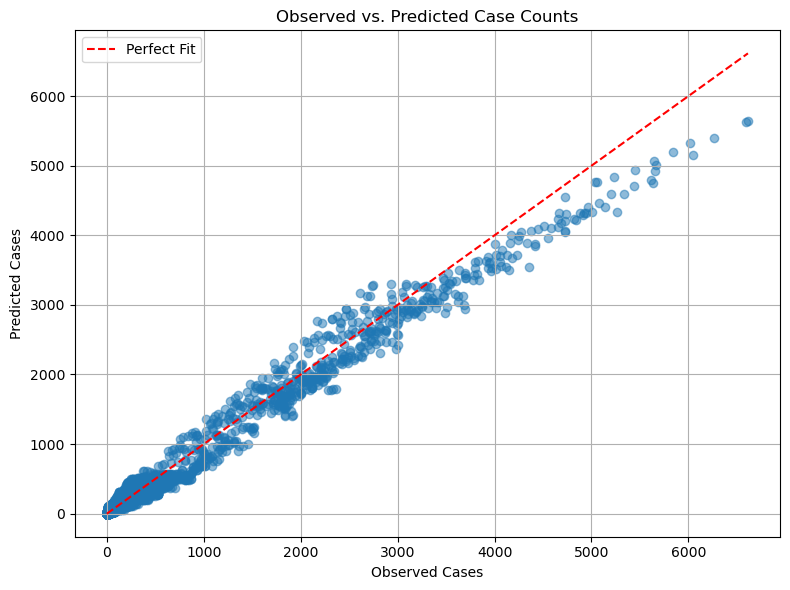

In [ ]:
# Visualize observed vs. predicted counts

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(colon_cancer_full['cases'], colon_cancer_full['predicted_counts'], alpha=0.5)
plt.plot([colon_cancer_full['cases'].min(), colon_cancer_full['cases'].max()],
         [colon_cancer_full['cases'].min(), colon_cancer_full['cases'].max()],
         'r--', label='Perfect Fit')
plt.xlabel('Observed Cases')
plt.ylabel('Predicted Cases')
plt.title('Observed vs. Predicted Case Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

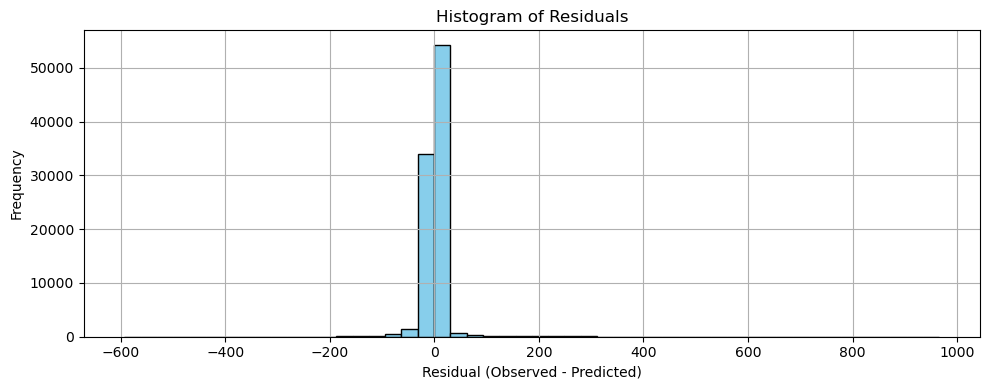

In [ ]:
# Plot residuals
colon_cancer_full['residuals'] = colon_cancer_full['cases'] - colon_cancer_full['predicted_counts']

plt.figure(figsize=(10, 4))
plt.hist(colon_cancer_full['residuals'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual (Observed - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

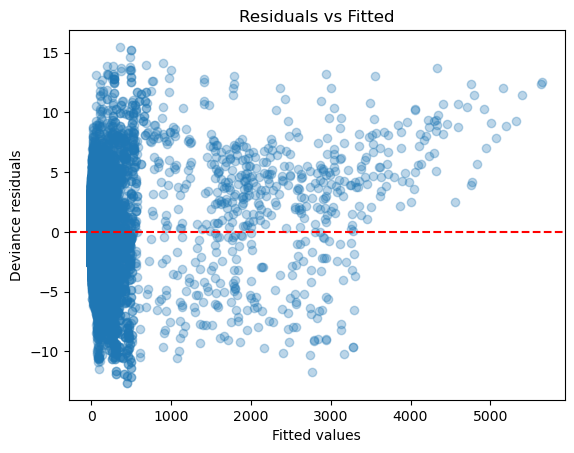

In [44]:
# Residuals vs Fitted plot

fitted = poisson_results.fittedvalues
residuals = poisson_results.resid_deviance

plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted")
plt.show()


In [43]:
# Test for overdispersion
mean_counts = colon_cancer_full['predicted_counts'].mean()
var_counts = colon_cancer_full['predicted_counts'].var()
overdispersion_ratio = var_counts / mean_counts
print(f"Mean of predicted counts: {mean_counts:.2f}")
print(f"Variance of predicted counts: {var_counts:.2f}")
print(f"Overdispersion ratio (Variance/Mean): {overdispersion_ratio:.2f}\n")

deviance = poisson_results.deviance
df_resid = poisson_results.df_resid
dispersion = deviance / df_resid
print("Dispersion:", dispersion)
if dispersion > 1.5:
    print("Evidence of overdispersion detected.")

Mean of predicted counts: 33.42
Variance of predicted counts: 42309.48
Overdispersion ratio (Variance/Mean): 1265.99

Dispersion: 3.3543179571787443
Evidence of overdispersion detected.


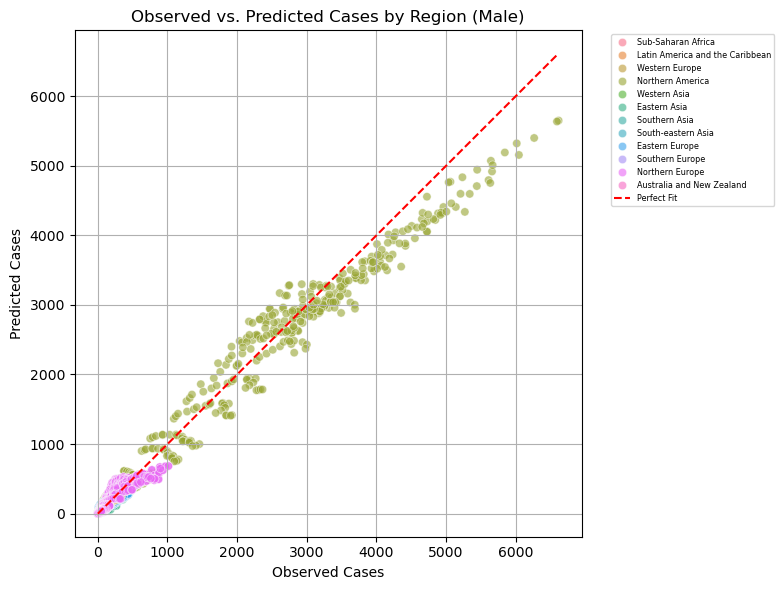

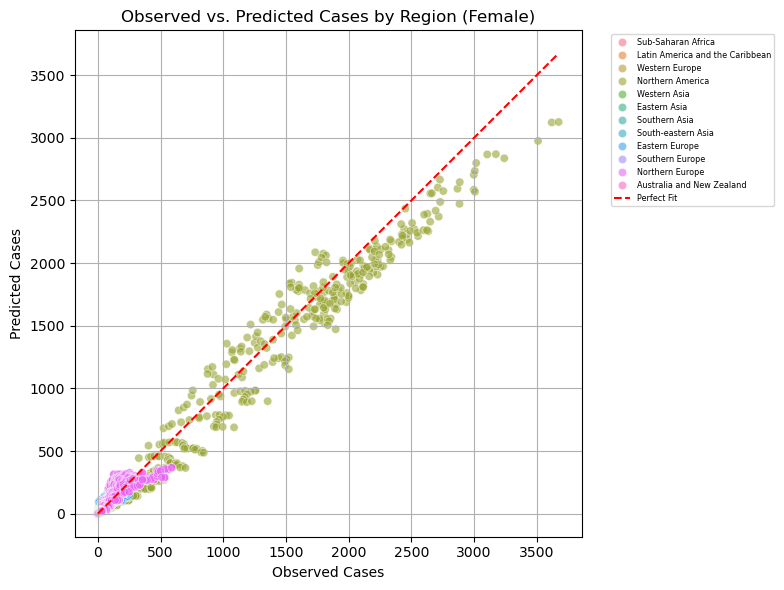

In [ ]:
# Stratified scatter plots: Observed vs. Predicted by sex_label, colored by region

import matplotlib.pyplot as plt
import seaborn as sns

for sex in colon_cancer_full['sex_label'].unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['sex_label'] == sex]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region ({sex})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

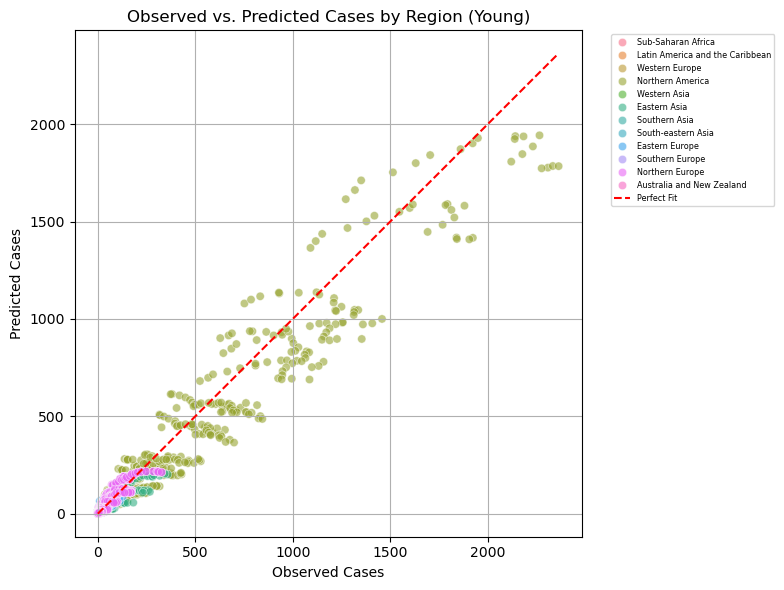

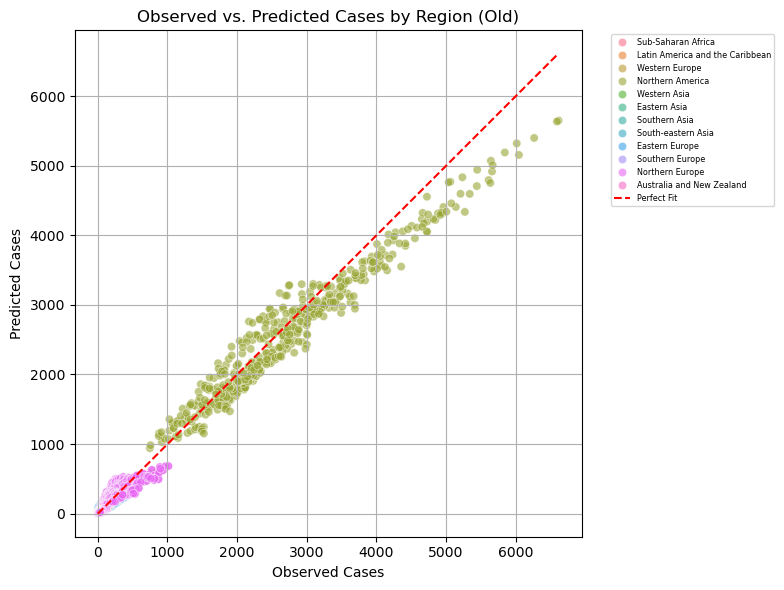

In [ ]:
# Stratified scatter plots: Observed vs. Predicted by age_group, colored by region

for age_group in colon_cancer_full['age_group'].unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['age_group'] == age_group]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region ({age_group})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

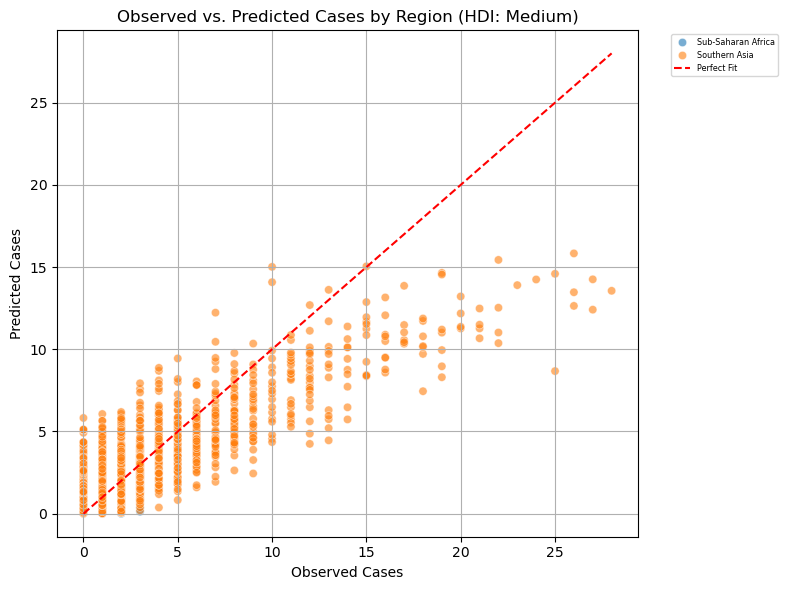

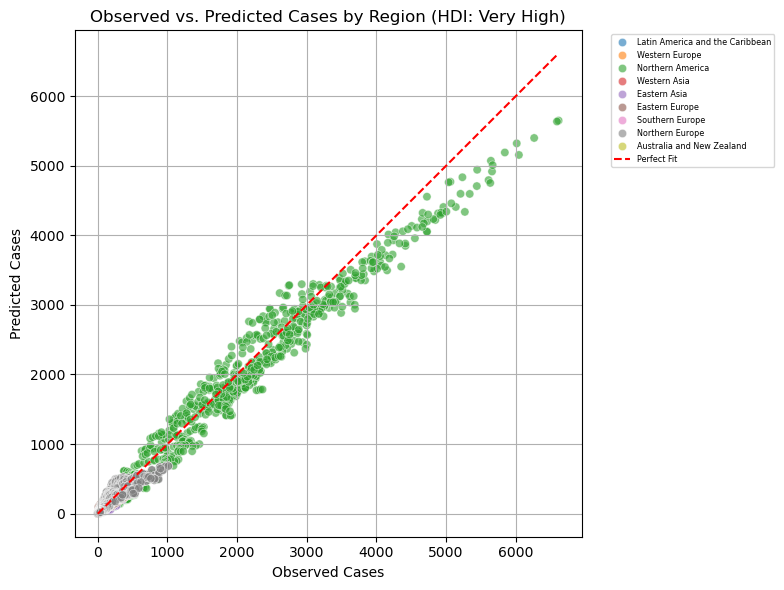

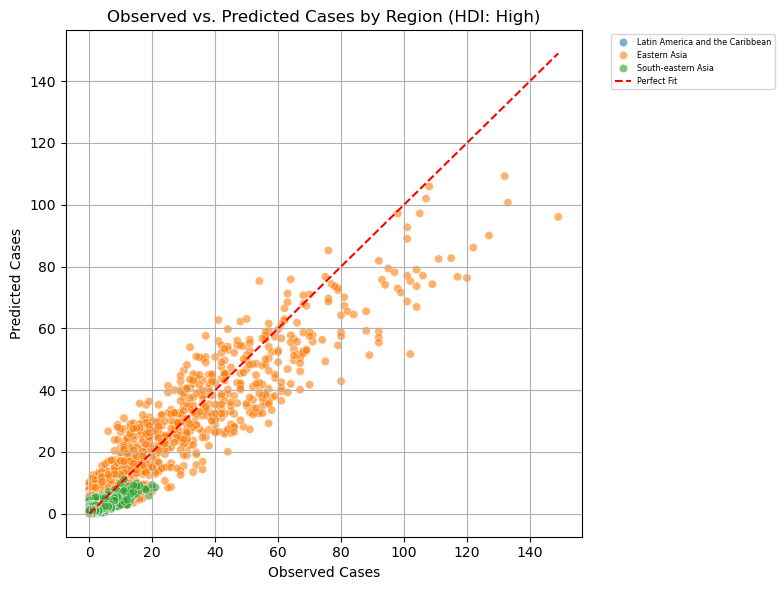

In [ ]:

# Stratified scatter plots: Observed vs. Predicted by hdi_category, colored by region
for hdi_cat in colon_cancer_full['hdi_category'].dropna().unique():
    plt.figure(figsize=(8, 6))
    subset = colon_cancer_full[colon_cancer_full['hdi_category'] == hdi_cat]
    sns.scatterplot(
        data=subset,
        x='cases',
        y='predicted_counts',
        hue='region',
        alpha=0.6
    )
    plt.plot([subset['cases'].min(), subset['cases'].max()],
             [subset['cases'].min(), subset['cases'].max()],
             'r--', label='Perfect Fit')
    plt.xlabel('Observed Cases')
    plt.ylabel('Predicted Cases')
    plt.title(f'Observed vs. Predicted Cases by Region (HDI: {hdi_cat})')
    plt.legend(fontsize='xx-small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Model summary review:


**Age (Spline Terms)**
- The coefficients for ``bs(age_cont, df=4, include_intercept=False)[0-3]`` represent the effect of age on colon cancer incidence, modeled flexibly using cubic splines.
- All spline coefficients are large, positive, and highly significant (p < 0.001), indicating a strong, non-linear relationship between age and incidence. As age increases, the risk of colon cancer rises sharply, but the exact shape is best visualized as a curve rather than interpreted term-by-term.

**Sex**
- **Male:**
    - Coefficient: **0.7070** (p < 0.001)
    - Interpretation: Males have a higher incidence rate than females.
    - The incidence rate ratio (IRR) is exp(0.7070) ≈ 2.03, meaning males have about twice the incidence rate of females, holding other variables constant.

**Region**
- Each region’s coefficient is compared to the reference region - Australia and New Zealand.
- **Positive coefficients** (e.g., Eastern Europe: **0.4497**, Northern America: 0.2708) mean higher incidence rates than Australia and New Zealand.
- **Negative coefficients** (e.g., Eastern Asia: **-0.4254**, Sub-Saharan Africa: **-2.0515**) mean lower incidence rates than Australia and New Zealand.
- For example:
    - **Eastern Europe**: `exp(0.4497) ≈ 1.57` → 57% higher incidence than Australia and New Zealand
    - **Eastern Asia:** `exp(-0.4254) ≈ 0.65` → 35% lower incidence than Australia and New Zealand
    **Sub-Saharan Africa:** `exp(-2.0515) ≈ 0.13` → 87% lower incidence than Australia and New Zealand

**Statistical Significance**
- All coefficients shown are highly statistically significant (p < 0.001), indicating strong evidence that age, sex, and region are important predictors of colon cancer incidence.

**Summary**
- **Age:** Strong, non-linear increase in risk with age.
- **Sex:** Males have about double the incidence rate of females.
- **Region:** Large differences by region, with some regions (e.g., Eastern Europe, Northern America) having much higher rates, and others (e.g., Sub-Saharan Africa, Eastern Asia) much lower, compared to Australia and New Zealand.



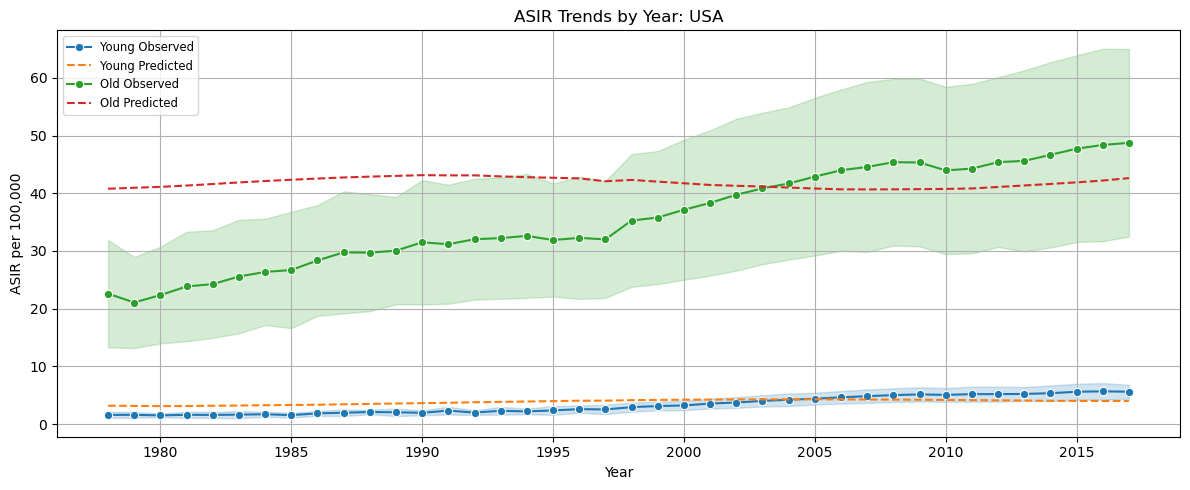

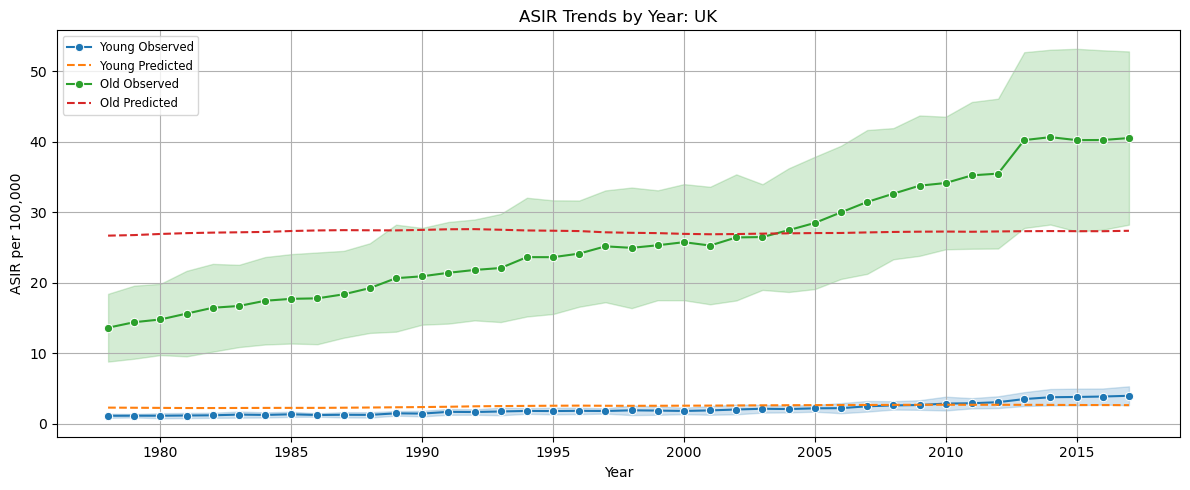

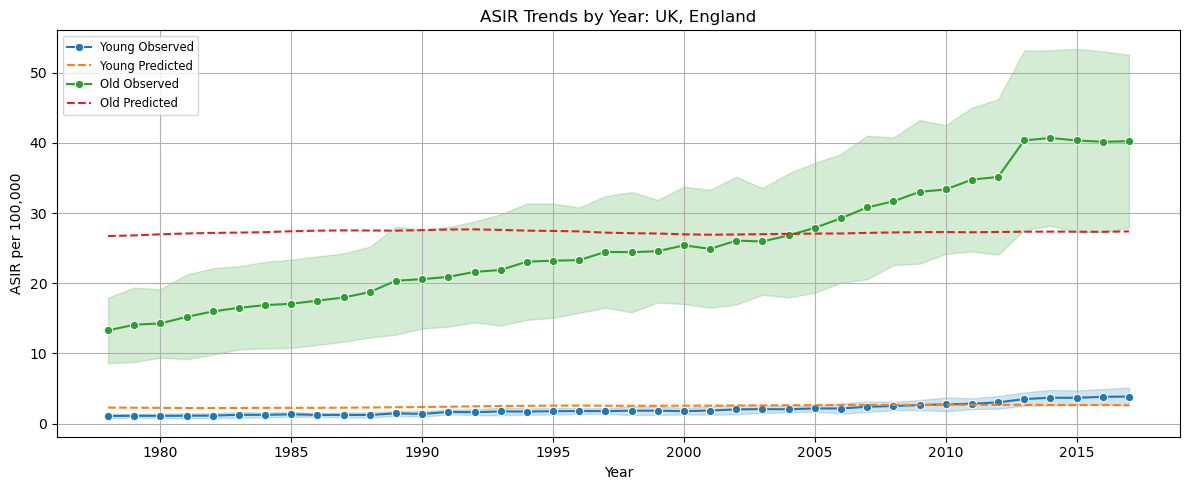

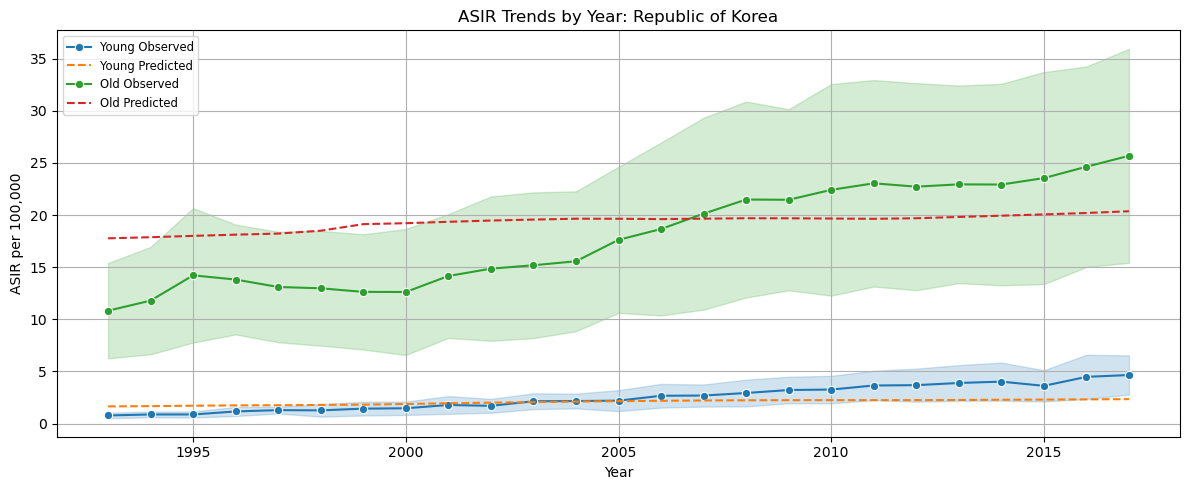

In [ ]:
# ASIR Trends by Year for Top 4 Countries

country_aggregated_df2 = pd.read_csv("data/country_aggregated_df2.csv")

# Select top 4 countries by total cases to plot
top_countries = country_aggregated_df2.groupby('country')['cases'].sum().nlargest(4).index.tolist()

for country in top_countries:
    plt.figure(figsize=(12, 5))
    for age_group in ['Young', 'Old']:
        df = country_aggregated_df2[(country_aggregated_df2['country'] == country) & (country_aggregated_df2['age_group'] == age_group)]
        sns.lineplot(data=df, x='year', y='ASIR', marker='o', label=f"{age_group} Observed")
        
        # Predicted: sum predicted_counts and py for each year, then calculate predicted ASIR
        pred_df = colon_cancer_full[
            (colon_cancer_full['country'] == country) &
            (colon_cancer_full['age_group'] == age_group)
        ].groupby('year').agg({'predicted_counts': 'sum', 'py': 'sum'}).reset_index()
        pred_df['pred_ASIR'] = pred_df['predicted_counts'] / pred_df['py'] * 100000
        sns.lineplot(data=pred_df, x='year', y='pred_ASIR', linestyle='--', label=f"{age_group} Predicted")
        
    plt.title(f"ASIR Trends by Year: {country}")
    plt.xlabel("Year")
    plt.ylabel("ASIR per 100,000")
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


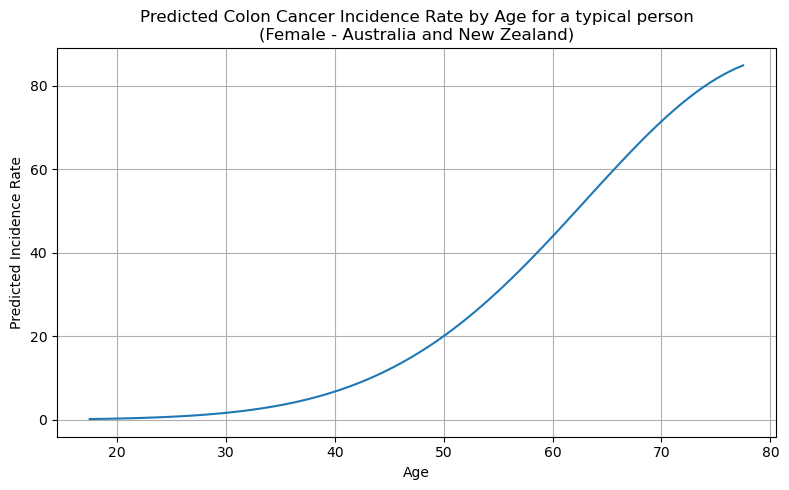

In [55]:
# Predicted Incidence Rate by Age# Generate a range of agesage_grid = np.linspace(colon_cancer_full['age_cont'].min(), colon_cancer_full['age_cont'].max(), 100)spline_basis_grid = dmatrix("bs(age_cont, df=4, include_intercept=False)",                             {"age_cont": age_grid}, return_type='dataframe')# Build the design matrix for prediction# Start with all zeros for all columns in XX_pred = pd.DataFrame(0, index=np.arange(len(age_grid)), columns=X.columns)# Set intercept to 1 (statsmodels uses 'const' as the column name)X_pred['const'] = 1.0# Fill spline columnsfor col in spline_basis_grid.columns:    X_pred[col] = spline_basis_grid[col].values# Set reference sex (Female: 0, Male: 1)if 'Male' in X_pred.columns:    X_pred['Male'] = 0.0  # Reference: Female# Set all region dummies to 0 (reference region)for col in X_pred.columns:    if col not in ['const'] + list(spline_basis_grid.columns) + ['Male']:        X_pred[col] = 0.0# Calculate mean log(py) for offset (representing a typical exposure)mean_log_py = np.log(colon_cancer_full['py']).replace([-np.inf, np.inf], np.nan).dropna().mean()# Predict (use mean log(py) as offset for visualization)predicted_rate = poisson_results.predict(X_pred, offset=mean_log_py)plt.figure(figsize=(8, 5))plt.plot(age_grid, predicted_rate)plt.xlabel('Age')plt.ylabel('Predicted Incidence Rate')plt.title('Predicted Colon Cancer Incidence Rate by Age for a typical person\n(Female - Australia and New Zealand)')plt.grid(True)plt.tight_layout()plt.show()

In [37]:
region_cols = [
    'Eastern Asia', 'Eastern Europe', 'Latin America and the Caribbean',
    'Northern America', 'Northern Europe', 'South-eastern Asia',
    'Southern Asia', 'Southern Europe', 'Sub-Saharan Africa',
    'Western Asia', 'Western Europe'
]
region_coefs = poisson_results.params[region_cols]
region_irrs = np.exp(region_coefs)

print("Incidence Rate Ratios (IRRs) for Regions vs. Reference:")
print(region_irrs)

Incidence Rate Ratios (IRRs) for Regions vs. Reference:
Eastern Asia                       0.653510
Eastern Europe                     1.567798
Latin America and the Caribbean    0.497602
Northern America                   1.311019
Northern Europe                    0.817611
South-eastern Asia                 0.236643
Southern Asia                      0.148588
Southern Europe                    0.897092
Sub-Saharan Africa                 0.128548
Western Asia                       0.841991
Western Europe                     1.025001
dtype: float64
